# A two-stage cyber attack detection and classification system for smart grids
https://www.sciencedirect.com/science/article/pii/S2542660523002494#b47

## Methodology
- Read all DNP3 parsed data. i.e. unbalanced
- Make two copies i.e. one for attack detection (attack vs bengin) another for attack classification (only contains attack data)
- For each copies, perform random oversampling to handle class imbalance.
- Perform Recursive Feature Elimination (RFE) to get 13 features from 96. Use Random Forest Classifier to do so.
- Train RF, LR, DT, GNB, XGB for both steps.

### Read Data
- First copy all CSV files into a local folder to make it easier to run.


In [35]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

In [36]:
def load_csv_files(all_files: list[Path]) -> pd.DataFrame:
    """
    Load all CSV files into a single DataFrame.
    """
    if len(all_files) == 0:
        logger.warning("No CSV files found.")
        return pd.DataFrame()
    dataframes = []
    for file in all_files:
        logger.info(f"Loading {file}")

        df = pd.read_csv(file, low_memory=False)
        if "Label" in df.columns:
            if "No Label" in df["Label"].unique():
                del df["Label"]
        df.columns = [c.strip() for c in df.columns]
        dataframes.append(df)
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df


data_root = Path(r"E:\MSc Works\IDS\data\Custom_DNP3_Parser")
logger.info(f"Data root: {data_root}")
all_files = list(data_root.glob("*.csv"))
logger.info(f"Found {len(all_files)} files in {data_root}")

combined_df = load_csv_files(all_files)
logger.info(f"Combined DataFrame shape: {combined_df.shape}")

2025-05-18 17:46:24.021 | INFO     | __main__:<module>:23 - Data root: E:\MSc Works\IDS\data\Custom_DNP3_Parser
2025-05-18 17:46:24.029 | INFO     | __main__:<module>:25 - Found 71 files in E:\MSc Works\IDS\data\Custom_DNP3_Parser
2025-05-18 17:46:24.030 | INFO     | __main__:load_csv_files:10 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200508_DNP3_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Slave_05.pcapDNP3_FLOWLABELED.csv
2025-05-18 17:46:24.089 | INFO     | __main__:load_csv_files:10 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200514_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Attacker_01.pcapDNP3_FLOWLABELED.csv
2025-05-18 17:46:24.139 | INFO     | __main__:load_csv_files:10 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200514_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Attacker_02.pcapDNP3_FLOWLABELED.csv
2025-05-18 17:46:24.193 | INFO     | __main__:load_csv_files:10 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\2020051

#### Convert `firstPacketDIR` to binary
- 1 if Master 0 otherwise

In [37]:
combined_df.firstPacketDIR.value_counts()

firstPacketDIR
MASTER        31878
OUTSTATION     8542
Name: count, dtype: int64

In [38]:
combined_df.firstPacketDIR = combined_df["firstPacketDIR"].apply(
    lambda x: 1 if x == "MASTER" else 0
)
combined_df.firstPacketDIR.value_counts()

firstPacketDIR
1    31878
0     8542
Name: count, dtype: int64

In [39]:
combined_df.protocol.value_counts()

protocol
6    40420
Name: count, dtype: int64

### Remove Unwanted Features

In [40]:
ignore_columns = [
    "File",
    "flow ID",
    "binary_label",
    "Timestamp",
    "source IP",
    "destination IP",
    "date",
    "Unnamed: 0",
    "Unnamed: 0.1",
]
combined_df = combined_df[[c for c in combined_df.columns if c not in ignore_columns]]

### Clone and oversample

In [41]:
def oversample_class(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Oversample the specified class in the DataFrame.
    """
    logger.info(f"Before oversampling: {df[label].value_counts()}")
    label_counts = df[label].value_counts()
    max_count = label_counts.max()
    for lbl in label_counts.index:
        count = label_counts[lbl]
        if count < max_count:
            needed = max_count - count
            logger.info(f"Label {lbl} needs {needed} samples")
            oversample_df = df[df[label] == lbl].sample(needed, replace=True)
            df = pd.concat([df, oversample_df], ignore_index=True)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42, replace=False).reset_index(drop=True)
    logger.info(f"After oversampling: {df[label].value_counts()}")
    return df


def undersample_class(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Undersample the specified class in the DataFrame.
    """
    logger.info(f"Before undersampling: {df[label].value_counts()}")
    label_counts = df[label].value_counts()
    min_count = label_counts.min()
    for lbl in label_counts.index:
        count = label_counts[lbl]
        if count > min_count:
            needed = count - min_count
            logger.info(f"Label {lbl} needs to be reduced by {needed} samples")
            undersample_df = df[df[label] == lbl].sample(needed, replace=False)
            df = df.drop(undersample_df.index)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42, replace=False).reset_index(drop=True)
    logger.info(f"After undersampling: {df[label].value_counts()}")
    return df


clf_df = combined_df.query('Label!="NORMAL"').copy()
det_df = combined_df.copy()
det_df["Label"] = det_df["Label"].apply(
    lambda x: "NORMAL" if x == "NORMAL" else "MALICIOUS"
)
logger.info(f"clf_df shape: {clf_df.shape}")
logger.info(f"det_df shape: {det_df.shape}")

clf_df = oversample_class(clf_df, "Label")
det_df = oversample_class(det_df, "Label")
# det_df = undersample_class(det_df, "Label")

2025-05-18 17:46:27.360 | INFO     | __main__:<module>:48 - clf_df shape: (26040, 97)
2025-05-18 17:46:27.362 | INFO     | __main__:<module>:49 - det_df shape: (40420, 97)
2025-05-18 17:46:27.368 | INFO     | __main__:oversample_class:5 - Before oversampling: Label
DISABLE_UNSOLICITED    5760
COLD_RESTART           5760
WARM_RESTART           5760
DNP3_ENUMERATE         3380
DNP3_INFO              3342
INIT_DATA               692
STOP_APP                680
REPLAY                  666
Name: count, dtype: int64
2025-05-18 17:46:27.373 | INFO     | __main__:oversample_class:12 - Label DNP3_ENUMERATE needs 2380 samples
2025-05-18 17:46:27.398 | INFO     | __main__:oversample_class:12 - Label DNP3_INFO needs 2418 samples
2025-05-18 17:46:27.421 | INFO     | __main__:oversample_class:12 - Label INIT_DATA needs 5068 samples
2025-05-18 17:46:27.438 | INFO     | __main__:oversample_class:12 - Label STOP_APP needs 5080 samples
2025-05-18 17:46:27.464 | INFO     | __main__:oversample_class:12 - 

In [42]:
clf_df.Label.value_counts(), det_df.Label.value_counts()

(Label
 DNP3_INFO              5760
 REPLAY                 5760
 STOP_APP               5760
 DNP3_ENUMERATE         5760
 DISABLE_UNSOLICITED    5760
 INIT_DATA              5760
 WARM_RESTART           5760
 COLD_RESTART           5760
 Name: count, dtype: int64,
 Label
 NORMAL       26040
 MALICIOUS    26040
 Name: count, dtype: int64)

### RFE on Detection Dataset
- Authors mentioned that they used RF, LR, DT, GNB and XGB first on original data. 
- Then found RF got the best F1-Score. So they used RF for feature selection.
- Nothing has been mentioned about the preprocessing of the data i.e. scaling.

<Axes: xlabel='Label'>

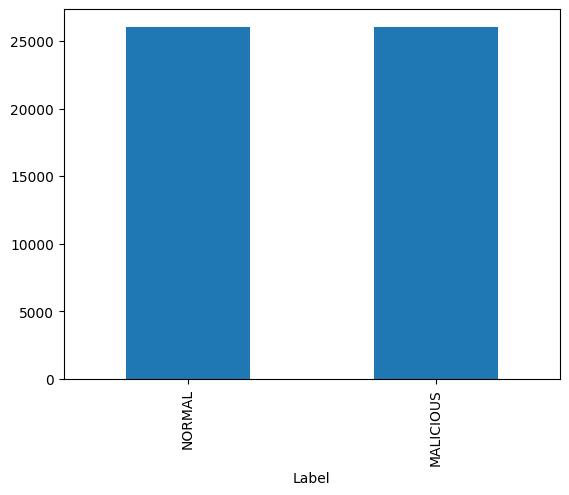

In [43]:
det_df.Label.value_counts().plot(kind="bar")

In [44]:
import time
from loguru import logger
import numpy as np
import pandas as pd
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance


class RFE:

    def __init__(
        self,
        model: ClassifierMixin,
        train_features: pd.DataFrame,
        train_labels: pd.Series,
        test_features: pd.DataFrame,
        test_labels: pd.Series,
    ):
        """
        Initialize the Recursive Feature Elimination (RFE) class with the given model and dataset.
            A scikit-learn compatible classifier model to be used for feature elimination.
            The training dataset features.
            The training dataset labels.
        test_features : pd.DataFrame
            The testing dataset features.
        test_labels : pd.Series
            The testing dataset labels.
        Attributes
            The classifier model provided for feature elimination.
        train_features : np.ndarray
            Scaled training dataset features.
            The training dataset labels.
        test_features : np.ndarray
            Scaled testing dataset features.
        test_labels : pd.Series
            The testing dataset labels.
        result : list
            A list to store the results of the feature elimination process.
        curr_step : int
            Tracks the current step in the feature elimination process.
        feature_mask : np.ndarray or None
            A mask indicating the selected features after elimination.
        orig_feature_names : list
            The original feature names from the training dataset.
        scaler : MinMaxScaler
            A MinMaxScaler instance used to scale the features.
        """
        self.model = model
        self.train_features = train_features
        self.train_labels = train_labels
        self.test_features = test_features
        self.test_labels = test_labels
        self.curr_step = 0
        self.feature_mask = None

        self.orig_feature_names = train_features.columns.tolist()

        # self.scaler = MinMaxScaler()
        # self.scaler.fit(self.train_features)
        # self.train_features = self.scaler.transform(self.train_features)
        # self.test_features = self.scaler.transform(self.test_features)
        self._result = []

    @property
    def result(self):
        """
        Returns the result of the feature elimination process.
        """
        cols = [
            "Step",
            "Removed Feature",
            "Max Feature",
            "Min Feature",
            "Max Importance",
            "Min Importance",
            "Score",
            "Num Features",
        ]
        if len(self._result) == 0:
            logger.warning("No results available. Please run the fit method first.")
            return pd.DataFrame(columns=cols)
        df = pd.DataFrame(self._result, columns=cols)
        return df

    def fit(self, feature_names: list | None = None):
        if feature_names is None:
            feature_names = self.orig_feature_names
        # init feat mask
        feature_mask = np.array([f in feature_names for f in self.orig_feature_names])

        if isinstance(self.train_features, pd.DataFrame):
            self.train_features = self.train_features.to_numpy()
        if isinstance(self.test_features, pd.DataFrame):
            self.test_features = self.test_features.to_numpy()

        x_train_sel = self.train_features[:, feature_mask]
        x_test_sel = self.test_features[:, feature_mask]
        current_indices = np.flatnonzero(feature_mask)
        current_feature_names = [self.orig_feature_names[i] for i in current_indices]
        logger.info(f"Step: {self.curr_step}, Feature Shape: {x_train_sel.shape}")
        model = clone(self.model)
        t0 = time.perf_counter()
        model.fit(x_train_sel, self.train_labels)
        # test_results = permutation_importance(
        #     model,
        #     x_test_sel,
        #     self.test_labels,
        #     n_repeats=10,
        #     random_state=42,
        #     n_jobs=-1,
        #     scoring="f1",
        # )

        # Evaluate on F1 score
        score = f1_score(self.test_labels, model.predict(x_test_sel), average="binary")
        # score = model.score(x_test_sel, self.test_labels)
        logger.info(
            f"Training time: {time.perf_counter() - t0:.4f}s, Score: {score:.4f}"
        )
        try:
            importances = model.feature_importances_
        except AttributeError:
            importances = model.coef_.flatten()
        # importances = test_results.importances_mean
        max_i = importances.argmax()
        min_i = importances.argmin()

        if feature_mask.sum() == 1:
            logger.info("Only one feature left, stopping")
            return self.result, self.current_feature_names
        # Eliminate least important feature
        remove_global_idx = current_indices[min_i]
        removed_feature_name = self.orig_feature_names[remove_global_idx]
        feature_mask[remove_global_idx] = False
        logger.info(
            f"Sum Imp. {sum(importances)} Max importance ({max_i}): {importances[max_i]:.4f} ({current_feature_names[max_i]}), Min importance ({min_i}): {importances[min_i]:.4f} ({current_feature_names[min_i]}), Removed feature: {removed_feature_name}"
        )
        self._result.append(
            [
                self.curr_step,
                removed_feature_name,
                current_feature_names[max_i],
                current_feature_names[min_i],
                importances[max_i],
                importances[min_i],
                score,
                x_test_sel.shape[1],
            ]
        )
        self.curr_step += 1
        self.current_feature_names = [
            self.orig_feature_names[i] for i in np.flatnonzero(feature_mask)
        ]
        self.feature_mask = feature_mask
        return self.result, self.current_feature_names

    def project(self, data: pd.DataFrame):

        data = data[:, self.feature_mask]

        return data

    def plot_results(self, fig_size: tuple = (10, 6)):
        """
        Plot the results of the RFE process.
        Parameters
        ----------
        fig_size : tuple
            The size of the figure to be plotted.
        """
        import matplotlib.pyplot as plt
        import seaborn as sns

        df = self.result
        # Sort normally
        df = df.sort_values(
            "Num Features", ascending=True
        )  # ascending=True so larger numbers are on the left
        max_score = df["Score"].max()
        max_score_idx = df["Score"].idxmax()

        # Plot with numeric x-axis
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df, x="Num Features", y="Score")
        # Highlight the maximum score point
        plt.scatter(
            df.loc[max_score_idx, "Num Features"],
            max_score,
            color="red",
            label=f"Max Score: {max_score:.4f}",
        )
        # annotate the max score point little below
        ann_txt = (df.loc[max_score_idx, "Num Features"] - 1, max_score - 0.001)
        plt.annotate(
            f"F1: {max_score:.4f}\nFeatures: {df.loc[max_score_idx, 'Num Features']}",
            xy=(df.loc[max_score_idx, "Num Features"], max_score),
            xytext=(df.loc[max_score_idx, "Num Features"] - 1.5, max_score - 0.002),
            arrowprops=dict(arrowstyle="->", color="gray"),
            fontsize=10,
            bbox=dict(
                boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8
            ),
        )

        # Reverse the x-axis
        plt.gca().invert_xaxis()

        plt.title(
            f"F1 Score vs Number of Features for ({self.model.__class__.__name__})"
        )
        plt.xlabel("Number of Features (Descending Order)")
        plt.ylabel("F1 Score")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#### DecisionTree

2025-05-18 18:21:56.610 | INFO     | __main__:fit:102 - Step: 0, Feature Shape: (39060, 96)
2025-05-18 18:21:57.453 | INFO     | __main__:fit:119 - Training time: 0.8420s, Score: 0.9975
2025-05-18 18:21:57.454 | INFO     | __main__:fit:137 - Sum Imp. 0.9999999999999998 Max importance (50): 0.6247 (bwdIAT_MEAN), Min importance (2): 0.0000 (protocol), Removed feature: protocol
2025-05-18 18:21:57.468 | INFO     | __main__:fit:102 - Step: 1, Feature Shape: (39060, 95)
2025-05-18 18:21:58.308 | INFO     | __main__:fit:119 - Training time: 0.8384s, Score: 0.9972
2025-05-18 18:21:58.309 | INFO     | __main__:fit:137 - Sum Imp. 1.0000000000000002 Max importance (49): 0.6248 (bwdIAT_MEAN), Min importance (0): 0.0000 (source port), Removed feature: source port
2025-05-18 18:21:58.322 | INFO     | __main__:fit:102 - Step: 2, Feature Shape: (39060, 94)
2025-05-18 18:21:59.110 | INFO     | __main__:fit:119 - Training time: 0.7866s, Score: 0.9977
2025-05-18 18:21:59.111 | INFO     | __main__:fit:13

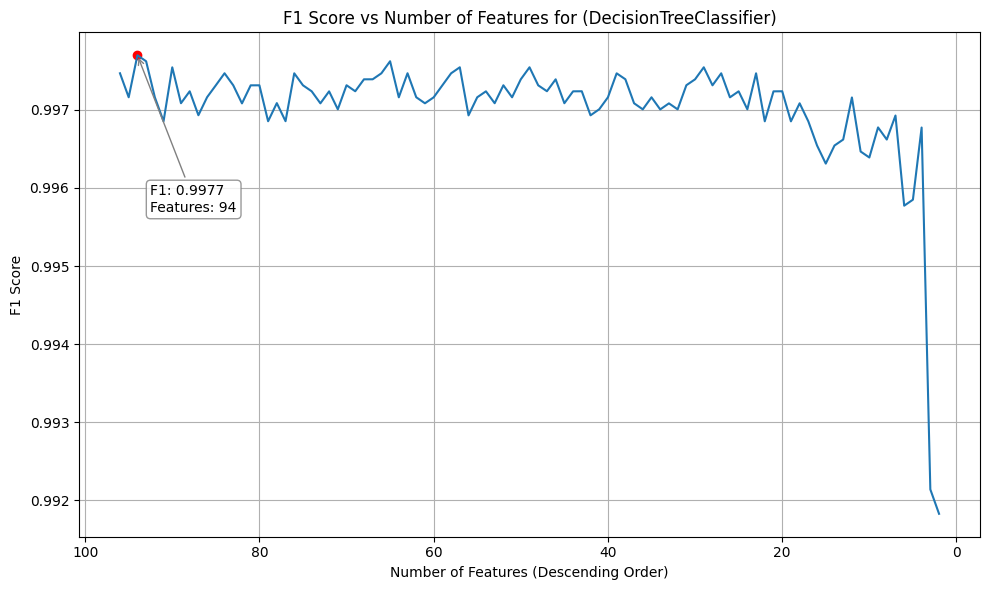

2025-05-18 18:22:41.384 | INFO     | __main__:<module>:47 - Top 10 features: ['bwdIAT_MEAN', 'TRbwdPktLenMIN', 'duration', 'FlowIAT_MIN', 'TotLenbwdDL', 'APPbwdPktLenMEAN', 'fwdIAT_MIN', 'IdleMIN', 'FlowIAT_MAX', 'APPfwdPktLenMEAN', 'bwdIAT_MIN']


In [68]:
from sklearn.model_selection import train_test_split
import os
import sys
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# sys.path.append(os.path.abspath(r"E:\MSc Works\IDS"))
# from ids_expt.data.rfe import RFE


# shuffle the data
ddf = det_df.copy().sample(frac=1.0, random_state=42, replace=False)

# Binary encode labels (MALICIOUS = 1, others = 0)
ddf["Label"] = ddf["Label"].apply(lambda x: 1 if x == "MALICIOUS" else 0)

# Stratified split
train_df, test_df = train_test_split(
    ddf, test_size=0.25, random_state=42, stratify=ddf["Label"]
)

X_train = train_df.drop(columns=["Label"])
y_train = train_df["Label"]
X_test = test_df.drop(columns=["Label"])
y_test = test_df["Label"]


# Initialize RFE
rfe = RFE(
    model=DecisionTreeClassifier(),  # Increase from default 100
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)

final_features = 1  # Target number of features
curr_features = X_train.columns.tolist()

for i in range(X_train.shape[1]):
    res, curr_features = rfe.fit(feature_names=curr_features)
    if len(curr_features) <= final_features:
        break
rfe.plot_results()
logger.info(
    f'Top 10 features: {curr_features + rfe.result["Removed Feature"].tolist()[::-1][:10]}'
)

#### RandomForest

2025-05-18 18:22:41.552 | INFO     | __main__:fit:102 - Step: 0, Feature Shape: (39060, 96)
2025-05-18 18:22:46.510 | INFO     | __main__:fit:119 - Training time: 4.9571s, Score: 0.9982
2025-05-18 18:22:46.523 | INFO     | __main__:fit:137 - Sum Imp. 0.9999999999999998 Max importance (50): 0.0580 (bwdIAT_MEAN), Min importance (2): 0.0000 (protocol), Removed feature: protocol
2025-05-18 18:22:46.538 | INFO     | __main__:fit:102 - Step: 1, Feature Shape: (39060, 95)
2025-05-18 18:22:51.554 | INFO     | __main__:fit:119 - Training time: 5.0142s, Score: 0.9979
2025-05-18 18:22:51.565 | INFO     | __main__:fit:137 - Sum Imp. 1.0000000000000002 Max importance (40): 0.0642 (FlowIAT_STD), Min importance (90): 0.0000 (corruptConfigFragments), Removed feature: corruptConfigFragments
2025-05-18 18:22:51.579 | INFO     | __main__:fit:102 - Step: 2, Feature Shape: (39060, 94)
2025-05-18 18:22:56.503 | INFO     | __main__:fit:119 - Training time: 4.9226s, Score: 0.9980
2025-05-18 18:22:56.515 | INF

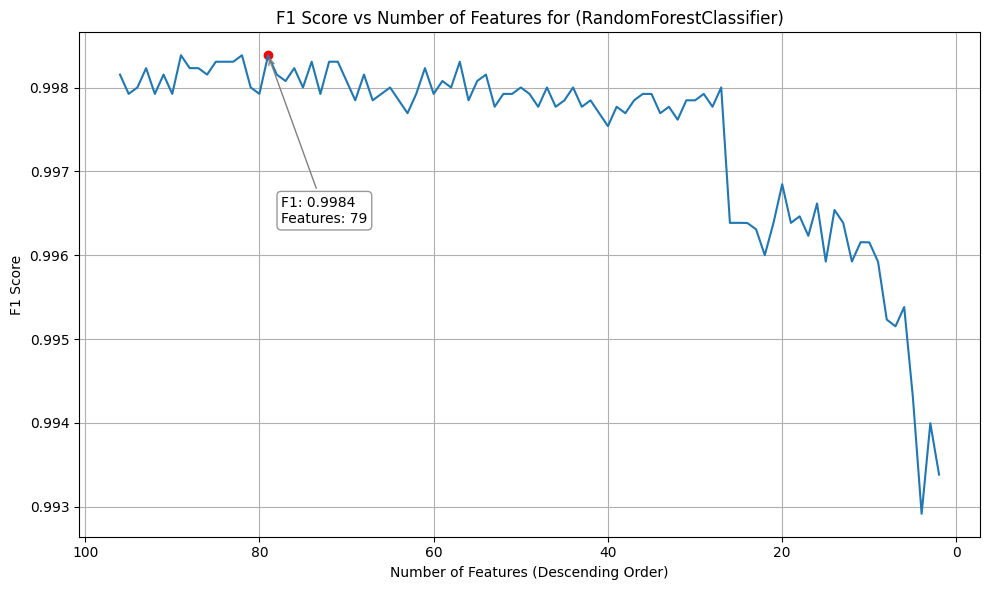

2025-05-18 18:30:16.191 | INFO     | __main__:<module>:42 - Top 10 features: ['DLflowBytes/sec', 'bwdIAT_MEAN', 'FlowIAT_STD', 'TRflowBytes/sec', 'pktsFromMASTER', 'TRfwdPktLenSTD', 'APPflowBytes/sec', 'FlowIAT_MAX', 'TRfwdHdrLen', 'APPfwdHdrLen', 'bwdIAT_MIN']


In [69]:
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


# shuffle the data
ddf = det_df.copy().sample(frac=1.0, random_state=42, replace=False)
# ddf = ddf[[c for c in ddf.columns if c not in ["frameSrc", "frameDst"]]]

# Binary encode labels (MALICIOUS = 1, others = 0)
ddf["Label"] = ddf["Label"].apply(lambda x: 1 if x == "MALICIOUS" else 0)

# Stratified split
train_df, test_df = train_test_split(
    ddf, test_size=0.25, random_state=42, stratify=ddf["Label"]
)

X_train = train_df.drop(columns=["Label"])
y_train = train_df["Label"]
X_test = test_df.drop(columns=["Label"])
y_test = test_df["Label"]


# Initialize RFE
rfe = RFE(
    model=RandomForestClassifier(),
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)

final_features = 1  # Target number of features
curr_features = X_train.columns.tolist()

for i in range(X_train.shape[1]):
    res, curr_features = rfe.fit(feature_names=curr_features)
    if len(curr_features) <= final_features:
        break
rfe.plot_results()
logger.info(
    f'Top 10 features: {curr_features + rfe.result["Removed Feature"].tolist()[::-1][:10]}'
)

In [121]:
# what happens to the accuracy and f1 if we remove the top 10 features
# shuffle the data
ddf = det_df.copy().sample(frac=1.0, random_state=42, replace=False)
# top_features = curr_features + rfe.result["Max Feature"].tolist()[::-1][:10]
# top_features = top_features + ddf.columns.tolist()[:95]
ddf["Label"] = ddf["Label"].apply(lambda x: 1 if x == "MALICIOUS" else 0)

# ddf = ddf[["protocol", "Label"]]
# # remove the top 10 features
# for feature in top_features:
#     if feature in ddf.columns:
#         del ddf[feature]


# Stratified split
train_df, test_df = train_test_split(
    ddf, test_size=0.25, random_state=42, stratify=ddf["Label"]
)

X_train = train_df.drop(columns=["Label"])
y_train = train_df["Label"]
X_test = test_df.drop(columns=["Label"])
y_test = test_df["Label"]

# scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average="binary")
acc = rf.score(X_test, y_test)
logger.info(f"Shape: {X_train.shape}, Accuracy: {acc:.4f}, F1: {f1:.4f}")

2025-05-18 20:17:23.411 | INFO     | __main__:<module>:37 - Shape: (39060, 1), Accuracy: 0.5000, F1: 0.6667


In [111]:
train_df.pktsFromSLAVE.describe()

count    39060.000000
mean         0.639291
std          0.399708
min          0.000000
25%          0.202899
50%          0.927536
75%          0.971014
max          1.000000
Name: pktsFromSLAVE, dtype: float64

#### LogisticRegression

2025-05-18 18:30:16.232 | INFO     | __main__:fit:102 - Step: 0, Feature Shape: (39060, 96)
2025-05-18 18:30:17.557 | INFO     | __main__:fit:119 - Training time: 1.3235s, Score: 0.9284
2025-05-18 18:30:17.558 | INFO     | __main__:fit:137 - Sum Imp. 2.3826020310274355e-05 Max importance (46): 0.0000 (fwdIAT_STD), Min importance (42): -0.0000 (FlowIAT_MAX), Removed feature: FlowIAT_MAX
2025-05-18 18:30:17.573 | INFO     | __main__:fit:102 - Step: 1, Feature Shape: (39060, 95)
2025-05-18 18:30:18.414 | INFO     | __main__:fit:119 - Training time: 0.8408s, Score: 0.9370
2025-05-18 18:30:18.416 | INFO     | __main__:fit:137 - Sum Imp. 1.3665381130519538e-05 Max importance (45): 0.0000 (fwdIAT_STD), Min importance (41): -0.0000 (FlowIAT_STD), Removed feature: FlowIAT_STD
2025-05-18 18:30:18.431 | INFO     | __main__:fit:102 - Step: 2, Feature Shape: (39060, 94)
2025-05-18 18:30:19.365 | INFO     | __main__:fit:119 - Training time: 0.9329s, Score: 0.9436
2025-05-18 18:30:19.366 | INFO     |

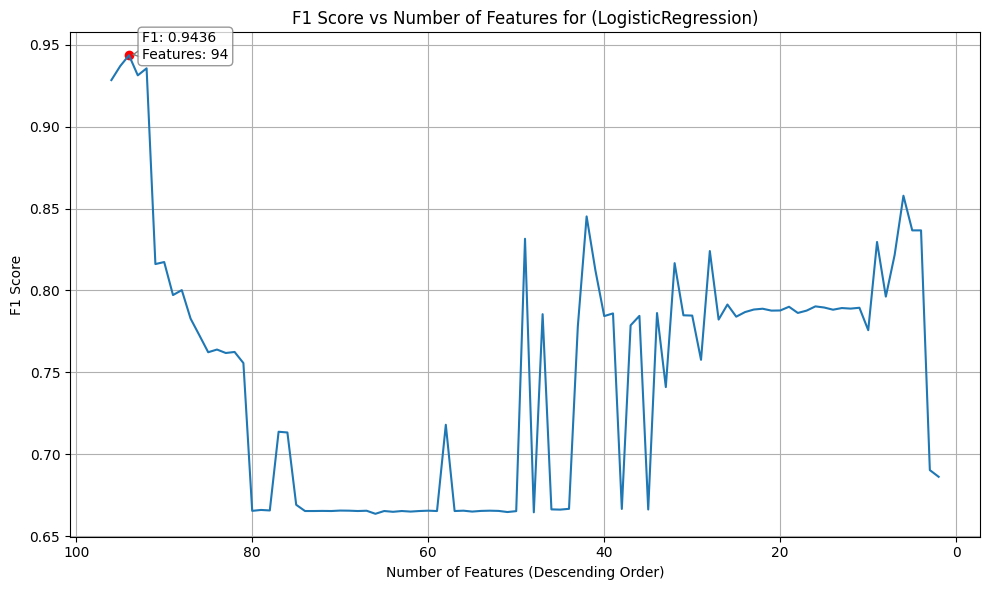

2025-05-18 18:31:12.412 | INFO     | __main__:<module>:23 - Top 10 features: ['APPbwdPktLenMAX', 'APPbwdHdrLen', 'FlowIAT_MIN', 'APPflowBytes/sec', 'deviceRestartFragments', 'firstPacketDIR', 'corruptConfigFragments', 'deviceTroubleFragments', 'frameDst', 'TotLenbwdTR', 'APPbwdPktLenSTD']


In [70]:
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Initialize RFE
rfe = RFE(
    model=LogisticRegression(max_iter=100),
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)

final_features = 1  # Target number of features
curr_features = X_train.columns.tolist()

for i in range(X_train.shape[1]):
    res, curr_features = rfe.fit(feature_names=curr_features)
    if len(curr_features) <= final_features:
        break
rfe.plot_results()
logger.info(
    f'Top 10 features: {curr_features + rfe.result["Removed Feature"].tolist()[::-1][:10]}'
)

#### XGB

2025-05-18 18:31:13.418 | INFO     | __main__:fit:102 - Step: 0, Feature Shape: (39060, 96)
2025-05-18 18:31:14.344 | INFO     | __main__:fit:119 - Training time: 0.9241s, Score: 0.9988
2025-05-18 18:31:14.361 | INFO     | __main__:fit:137 - Sum Imp. 1.0000000845921022 Max importance (50): 0.5226 (bwdIAT_MEAN), Min importance (2): 0.0000 (protocol), Removed feature: protocol
2025-05-18 18:31:14.378 | INFO     | __main__:fit:102 - Step: 1, Feature Shape: (39060, 95)
2025-05-18 18:31:15.027 | INFO     | __main__:fit:119 - Training time: 0.6474s, Score: 0.9988
2025-05-18 18:31:15.029 | INFO     | __main__:fit:137 - Sum Imp. 0.9999999815263436 Max importance (49): 0.5226 (bwdIAT_MEAN), Min importance (7): 0.0000 (TotLenfwdAPP), Removed feature: TotLenfwdAPP
2025-05-18 18:31:15.046 | INFO     | __main__:fit:102 - Step: 2, Feature Shape: (39060, 94)
2025-05-18 18:31:15.673 | INFO     | __main__:fit:119 - Training time: 0.6259s, Score: 0.9988
2025-05-18 18:31:15.675 | INFO     | __main__:fit:

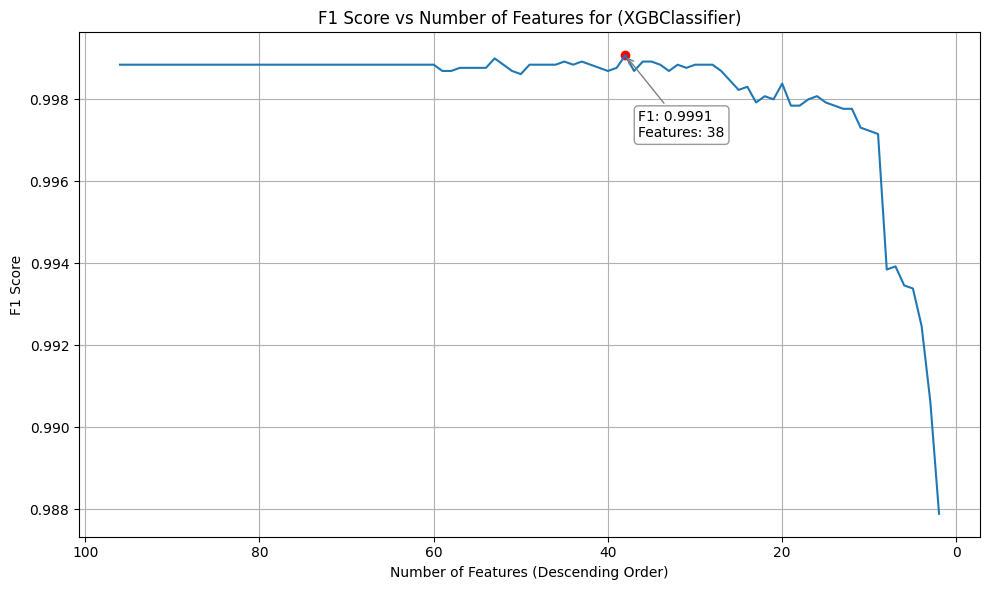

2025-05-18 18:31:53.084 | INFO     | __main__:<module>:21 - Top 10 features: ['DLbwdPktLenMIN', 'bwdIAT_MEAN', 'TotalBwdIAT', 'FlowIAT_MAX', 'pktsFromMASTER', 'DLfwdPktLenMIN', 'TotLenbwdDL', 'TotalFwdIAT', 'FlowIAT_MIN', 'TotalBwdPkts', 'fwdIAT_MAX']


In [71]:
# XGB
from xgboost import XGBClassifier


rfe = RFE(
    model=XGBClassifier(),
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)

final_features = 1  # Target number of features
curr_features = X_train.columns.tolist()

for i in range(X_train.shape[1]):
    res, curr_features = rfe.fit(feature_names=curr_features)
    if len(curr_features) <= final_features:
        break
rfe.plot_results()
logger.info(
    f'Top 10 features: {curr_features + rfe.result["Removed Feature"].tolist()[::-1][:10]}'
)

In [72]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# scaler
from sklearn.preprocessing import MinMaxScaler

# need RF, LR, DT, GNB and XGB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


class SKClassifiers:
    def __init__(
        self,
        models: list[BaseEstimator],
        train_features: pd.DataFrame,
        train_labels: pd.Series,
        test_features: pd.DataFrame,
        test_labels: pd.Series,
    ):

        self.models = models
        self.train_features = train_features
        self.train_labels = train_labels
        self.test_features = test_features
        self.test_labels = test_labels
        self.results = {}
        self.scaler = MinMaxScaler()
        self.scaler.fit(self.train_features)
        self.train_features = self.scaler.transform(self.train_features)
        self.test_features = self.scaler.transform(self.test_features)

    def fit(self):
        for model in self.models:
            model_name = type(model).__name__
            logger.info(f"Training {model_name}")
            model.fit(self.train_features, self.train_labels)
            y_pred = model.predict(self.test_features)
            accuracy = accuracy_score(self.test_labels, y_pred)
            report = classification_report(self.test_labels, y_pred, output_dict=True)
            self.results[model_name] = {
                "accuracy": accuracy,
                "report": report,
                "confusion_matrix": confusion_matrix(self.test_labels, y_pred),
                "f1_score": report["weighted avg"]["f1-score"],
                "precision": report["weighted avg"]["precision"],
                "recall": report["weighted avg"]["recall"],
            }
            logger.info(f"{model_name} Accuracy: {accuracy}")
        return self.results


clfs = [
    RandomForestClassifier(max_depth=15, n_estimators=100),
    DecisionTreeClassifier(max_depth=15),
    LogisticRegression(max_iter=1000),
    GaussianNB(),
    XGBClassifier(max_depth=15, n_estimators=100),
]
clf = SKClassifiers(
    models=clfs,
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)
results = clf.fit()
logger.info("Results:")
for model_name, result in results.items():
    logger.info(f"{model_name} Accuracy: {result['accuracy']}")
    logger.info(f"F1 Score: {result['f1_score']}")
    logger.info(f"Precision: {result['precision']}")
    logger.info(f"Recall: {result['recall']}")
    logger.info(f"Confusion Matrix:\n{result['confusion_matrix']}")

2025-05-18 18:31:53.188 | INFO     | __main__:fit:39 - Training RandomForestClassifier
2025-05-18 18:31:58.233 | INFO     | __main__:fit:52 - RandomForestClassifier Accuracy: 0.9982334869431644
2025-05-18 18:31:58.234 | INFO     | __main__:fit:39 - Training DecisionTreeClassifier
2025-05-18 18:31:59.017 | INFO     | __main__:fit:52 - DecisionTreeClassifier Accuracy: 0.9971582181259601
2025-05-18 18:31:59.018 | INFO     | __main__:fit:39 - Training LogisticRegression
2025-05-18 18:31:59.741 | INFO     | __main__:fit:52 - LogisticRegression Accuracy: 0.9802611367127496
2025-05-18 18:31:59.742 | INFO     | __main__:fit:39 - Training GaussianNB
2025-05-18 18:31:59.849 | INFO     | __main__:fit:52 - GaussianNB Accuracy: 0.629416282642089
2025-05-18 18:31:59.850 | INFO     | __main__:fit:39 - Training XGBClassifier
2025-05-18 18:32:00.618 | INFO     | __main__:fit:52 - XGBClassifier Accuracy: 0.998694316436252
2025-05-18 18:32:00.620 | INFO     | __main__:<module>:71 - Results:
2025-05-18 18

## Attacking and Defending DNP3 ICS/SCADA Systems

In [122]:
import pandas as pd
from pathlib import Path
from loguru import logger


def load_csv_files(all_files: list[Path]) -> pd.DataFrame:
    """
    Load all CSV files into a single DataFrame.
    """
    if len(all_files) == 0:
        logger.warning("No CSV files found.")
        return pd.DataFrame()

    dataframes = []
    for file in all_files:
        logger.info(f"Loading {file}")
        df = pd.read_csv(file, low_memory=False)
        if "Label" in df.columns:
            if "No Label" in df["Label"].unique():
                del df["Label"]

        df.columns = [c.strip() for c in df.columns]
        dataframes.append(df)
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df


data_root = Path(r"E:\MSc Works\IDS\data\Custom_DNP3_Parser")
logger.info(f"Data root: {data_root}")
all_files = list(data_root.glob("*.csv"))
logger.info(f"Found {len(all_files)} files in {data_root}")
combined_df = load_csv_files(all_files)
logger.info(f"Combined DataFrame shape: {combined_df.shape}")

2025-05-18 22:51:17.318 | INFO     | __main__:<module>:29 - Data root: E:\MSc Works\IDS\data\Custom_DNP3_Parser
2025-05-18 22:51:17.351 | INFO     | __main__:<module>:31 - Found 71 files in E:\MSc Works\IDS\data\Custom_DNP3_Parser
2025-05-18 22:51:17.353 | INFO     | __main__:load_csv_files:16 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200508_DNP3_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Slave_05.pcapDNP3_FLOWLABELED.csv
2025-05-18 22:51:17.927 | INFO     | __main__:load_csv_files:16 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200514_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Attacker_01.pcapDNP3_FLOWLABELED.csv
2025-05-18 22:51:17.972 | INFO     | __main__:load_csv_files:16 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\20200514_Disable_Unsolicited_Messages_Attack_UOWM_DNP3_Dataset_Attacker_02.pcapDNP3_FLOWLABELED.csv
2025-05-18 22:51:18.027 | INFO     | __main__:load_csv_files:16 - Loading E:\MSc Works\IDS\data\Custom_DNP3_Parser\2020051

In [123]:
ignore_columns = [
    "File",
    "flow ID",
    "binary_label",
    "Timestamp",
    "source IP",
    "destination IP",
    "date",
    "Unnamed: 0",
    "Unnamed: 0.1",
    "firstPacketDIR",
]
combined_df = combined_df[[c for c in combined_df.columns if c not in ignore_columns]]
# combined_df.firstPacketDIR = combined_df["firstPacketDIR"].apply(
#     lambda x: 1 if x == "MASTER" else 0
# )

In [124]:
def oversample_class(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Oversample the specified class in the DataFrame.
    """
    logger.info(f"Before oversampling: {df[label].value_counts()}")
    label_counts = df[label].value_counts()
    max_count = label_counts.max()
    for lbl in label_counts.index:
        count = label_counts[lbl]
        if count < max_count:
            needed = max_count - count
            logger.info(f"Label {lbl} needs {needed} samples")
            oversample_df = df[df[label] == lbl].sample(needed, replace=True)
            df = pd.concat([df, oversample_df], ignore_index=True)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42, replace=False).reset_index(drop=True)
    logger.info(f"After oversampling: {df[label].value_counts()}")
    return df


def undersample_class(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Undersample the specified class in the DataFrame.
    """
    logger.info(f"Before undersampling: {df[label].value_counts()}")
    label_counts = df[label].value_counts()
    min_count = label_counts.min()
    for lbl in label_counts.index:
        count = label_counts[lbl]
        if count > min_count:
            needed = count - min_count
            logger.info(f"Label {lbl} needs to be reduced by {needed} samples")
            undersample_df = df[df[label] == lbl].sample(needed, replace=False)
            df = df.drop(undersample_df.index)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42, replace=False).reset_index(drop=True)
    logger.info(f"After undersampling: {df[label].value_counts()}")
    return df

### Modelling

In [125]:
# DT, DNN, KNN, NB, RF
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

# scaler
from sklearn.preprocessing import MinMaxScaler

RF = RandomForestClassifier(random_state=42)
DT = DecisionTreeClassifier(random_state=42)
KNN = KNeighborsClassifier()
NB = GaussianNB()
models = [RF, DT, KNN, NB]

# shuffle the data
ddf = combined_df.copy().sample(frac=1.0, random_state=42, replace=False)

X = ddf.drop("Label", axis=1).values
y = ddf["Label"]

# Normalization to [0,1] range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# sclaer
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# fit
for model in models:
    model_name = type(model).__name__
    logger.info(f"Training {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    logger.info(f"{model_name} Accuracy: {accuracy}")
    logger.info(f"{model_name} F1 Score: {f1}")

2025-05-18 22:51:21.106 | INFO     | __main__:<module>:43 - Training RandomForestClassifier
2025-05-18 22:51:30.040 | INFO     | __main__:<module>:48 - RandomForestClassifier Accuracy: 0.964745175655616
2025-05-18 22:51:30.041 | INFO     | __main__:<module>:49 - RandomForestClassifier F1 Score: 0.9648139539363886
2025-05-18 22:51:30.042 | INFO     | __main__:<module>:43 - Training DecisionTreeClassifier
2025-05-18 22:51:30.981 | INFO     | __main__:<module>:48 - DecisionTreeClassifier Accuracy: 0.9745175655616032
2025-05-18 22:51:30.982 | INFO     | __main__:<module>:49 - DecisionTreeClassifier F1 Score: 0.9745238553739216
2025-05-18 22:51:30.982 | INFO     | __main__:<module>:43 - Training KNeighborsClassifier
2025-05-18 22:51:32.100 | INFO     | __main__:<module>:48 - KNeighborsClassifier Accuracy: 0.9716724393864423
2025-05-18 22:51:32.101 | INFO     | __main__:<module>:49 - KNeighborsClassifier F1 Score: 0.971965316743756
2025-05-18 22:51:32.102 | INFO     | __main__:<module>:43 - 

### Keras

In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load dataset (replace with your DNP3 flow data)
df = combined_df.copy()

# Preprocessing
X = df.drop("Label", axis=1).values
y = pd.get_dummies(df["Label"]).values  # One-hot encoding

# Normalization to [0,1] range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

# DNN Architecture
dnn_model = Sequential(
    [
        Dense(90, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(90, activation="relu"),
        Dense(y_train.shape[1], activation="softmax"),
    ]
)

# Compile model
optimizer = Adam(learning_rate=0.0001)
dnn_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

# Training
history = dnn_model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True),
        ModelCheckpoint(
            "dnp3_best_model.h5", monitor="val_loss", save_best_only=True, verbose=1
        ),
    ],
)

# Evaluation
loss, accuracy = dnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

e:\MSc Works\IDS\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
937/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5056 - loss: 1.2828
Epoch 1: val_loss improved from inf to 0.43895, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5074 - loss: 1.2768 - val_accuracy: 0.7590 - val_loss: 0.4389
Epoch 2/1000
935/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7561 - loss: 0.4310
Epoch 2: val_loss improved from 0.43895 to 0.39104, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7562 - loss: 0.4309 - val_accuracy: 0.7818 - val_loss: 0.3910
Epoch 3/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7758 - loss: 0.3927
Epoch 3: val_loss improved from 0.39104 to 0.35837, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7759 - loss: 0.3926 - val_accuracy: 0.8005 - val_loss: 0.3584
Epoch 4/1000
929/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7910 - loss: 0.3667
Epoch 4: val_loss did not improve from 0.35837
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7910 - loss: 0.3667 - val_accuracy: 0.7928 - val_loss: 0.3633
Epoch 5/1000
929/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.3662
Epoch 5: val_loss improved from 0.35837 to 0.33888, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7907 - loss: 0.3661 - val_accuracy: 0.7948 - val_loss: 0.3389
Epoch 6/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7987 - loss: 0.3563
Epoch 6: val_loss did not improve from 0.33888
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7987 - loss: 0.3562 - val_accuracy: 0.8139 - val_loss: 0.3499
Epoch 7/1000
930/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8037 - loss: 0.3489
Epoch 7: val_loss did not improve from 0.33888
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8037 - loss: 0.3490 - val_accuracy: 0.8199 - val_loss: 0.3397
Epoch 8/1000
931/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.3473
Epoch 8: val_loss did not improve from 0.33888
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8028 - loss: 0.3473 - val_accuracy: 0.7189 - val_loss: 0.5305
Epoch 9/1000
930/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8002 - loss: 0.3544
Epoch 9: val_loss improved from 0.33888

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8003 - loss: 0.3543 - val_accuracy: 0.8168 - val_loss: 0.3385
Epoch 10/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - loss: 0.3439
Epoch 10: val_loss improved from 0.33850 to 0.33685, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8047 - loss: 0.3439 - val_accuracy: 0.7941 - val_loss: 0.3369
Epoch 11/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8142 - loss: 0.3378
Epoch 11: val_loss improved from 0.33685 to 0.32784, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8141 - loss: 0.3378 - val_accuracy: 0.8234 - val_loss: 0.3278
Epoch 12/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8172 - loss: 0.3322
Epoch 12: val_loss improved from 0.32784 to 0.32102, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8172 - loss: 0.3323 - val_accuracy: 0.8323 - val_loss: 0.3210
Epoch 13/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8141 - loss: 0.3331
Epoch 13: val_loss improved from 0.32102 to 0.32007, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8141 - loss: 0.3331 - val_accuracy: 0.8332 - val_loss: 0.3201
Epoch 14/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8276 - loss: 0.3245
Epoch 14: val_loss improved from 0.32007 to 0.30181, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8276 - loss: 0.3245 - val_accuracy: 0.8467 - val_loss: 0.3018
Epoch 15/1000
937/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8299 - loss: 0.3171
Epoch 15: val_loss did not improve from 0.30181
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8299 - loss: 0.3171 - val_accuracy: 0.8366 - val_loss: 0.3162
Epoch 16/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.3091
Epoch 16: val_loss improved from 0.30181 to 0.28883, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8357 - loss: 0.3091 - val_accuracy: 0.8439 - val_loss: 0.2888
Epoch 17/1000
930/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8372 - loss: 0.3034
Epoch 17: val_loss did not improve from 0.28883
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8372 - loss: 0.3033 - val_accuracy: 0.8526 - val_loss: 0.2934
Epoch 18/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.2990
Epoch 18: val_loss did not improve from 0.28883
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8427 - loss: 0.2991 - val_accuracy: 0.8447 - val_loss: 0.2929
Epoch 19/1000
927/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8425 - loss: 0.2977
Epoch 19: val_loss did not improve from 0.28883
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8424 - loss: 0.2977 - val_accuracy: 0.8402 - val_loss: 0.2996
Epoch 20/1000
946/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8398 - loss: 0.2996
Epoch 20: val_loss improved from

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8398 - loss: 0.2996 - val_accuracy: 0.8538 - val_loss: 0.2862
Epoch 21/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.2921
Epoch 21: val_loss improved from 0.28625 to 0.28601, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8448 - loss: 0.2921 - val_accuracy: 0.8683 - val_loss: 0.2860
Epoch 22/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.2898
Epoch 22: val_loss did not improve from 0.28601
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8480 - loss: 0.2898 - val_accuracy: 0.8419 - val_loss: 0.2895
Epoch 23/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.2883
Epoch 23: val_loss improved from 0.28601 to 0.27986, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8454 - loss: 0.2883 - val_accuracy: 0.8510 - val_loss: 0.2799
Epoch 24/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.2839
Epoch 24: val_loss did not improve from 0.27986
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8438 - loss: 0.2839 - val_accuracy: 0.8316 - val_loss: 0.3181
Epoch 25/1000
933/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8470 - loss: 0.2862
Epoch 25: val_loss improved from 0.27986 to 0.27130, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8470 - loss: 0.2861 - val_accuracy: 0.8574 - val_loss: 0.2713
Epoch 26/1000
930/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8520 - loss: 0.2772
Epoch 26: val_loss improved from 0.27130 to 0.26991, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8519 - loss: 0.2773 - val_accuracy: 0.8566 - val_loss: 0.2699
Epoch 27/1000
936/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8506 - loss: 0.2795
Epoch 27: val_loss did not improve from 0.26991
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8506 - loss: 0.2795 - val_accuracy: 0.8567 - val_loss: 0.2835
Epoch 28/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.2735
Epoch 28: val_loss did not improve from 0.26991
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8531 - loss: 0.2734 - val_accuracy: 0.8505 - val_loss: 0.2804
Epoch 29/1000
939/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8611 - loss: 0.2691
Epoch 29: val_loss improved from 0.26991 to 0.25091, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8611 - loss: 0.2691 - val_accuracy: 0.8638 - val_loss: 0.2509
Epoch 30/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8586 - loss: 0.2680
Epoch 30: val_loss did not improve from 0.25091
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8586 - loss: 0.2680 - val_accuracy: 0.8397 - val_loss: 0.2815
Epoch 31/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8634 - loss: 0.2634
Epoch 31: val_loss did not improve from 0.25091
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8634 - loss: 0.2634 - val_accuracy: 0.8629 - val_loss: 0.2644
Epoch 32/1000
935/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.2661
Epoch 32: val_loss did not improve from 0.25091
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8599 - loss: 0.2660 - val_accuracy: 0.8448 - val_loss: 0.2740
Epoch 33/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8624 - loss: 0.2602
Epoch 33: val_loss improved from

948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8624 - loss: 0.2602 - val_accuracy: 0.8823 - val_loss: 0.2464
Epoch 34/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.2493
Epoch 34: val_loss improved from 0.24643 to 0.23702, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8692 - loss: 0.2493 - val_accuracy: 0.8762 - val_loss: 0.2370
Epoch 35/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8680 - loss: 0.2449
Epoch 35: val_loss did not improve from 0.23702
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8680 - loss: 0.2450 - val_accuracy: 0.8693 - val_loss: 0.2404
Epoch 36/1000
946/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8753 - loss: 0.2365
Epoch 36: val_loss did not improve from 0.23702
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8753 - loss: 0.2365 - val_accuracy: 0.8692 - val_loss: 0.2639
Epoch 37/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8725 - loss: 0.2413
Epoch 37: val_loss improved from 0.23702 to 0.22896, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8725 - loss: 0.2413 - val_accuracy: 0.8721 - val_loss: 0.2290
Epoch 38/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8769 - loss: 0.2307
Epoch 38: val_loss improved from 0.22896 to 0.22240, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8769 - loss: 0.2307 - val_accuracy: 0.8788 - val_loss: 0.2224
Epoch 39/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8781 - loss: 0.2323
Epoch 39: val_loss did not improve from 0.22240
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8781 - loss: 0.2323 - val_accuracy: 0.8864 - val_loss: 0.2295
Epoch 40/1000
930/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8835 - loss: 0.2165
Epoch 40: val_loss improved from 0.22240 to 0.21579, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8835 - loss: 0.2166 - val_accuracy: 0.8841 - val_loss: 0.2158
Epoch 41/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8844 - loss: 0.2222
Epoch 41: val_loss did not improve from 0.21579
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8844 - loss: 0.2222 - val_accuracy: 0.8864 - val_loss: 0.2197
Epoch 42/1000
931/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8861 - loss: 0.2153
Epoch 42: val_loss improved from 0.21579 to 0.19272, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8861 - loss: 0.2152 - val_accuracy: 0.8983 - val_loss: 0.1927
Epoch 43/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8916 - loss: 0.2037
Epoch 43: val_loss did not improve from 0.19272
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8916 - loss: 0.2037 - val_accuracy: 0.8931 - val_loss: 0.2068
Epoch 44/1000
932/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8955 - loss: 0.2020
Epoch 44: val_loss did not improve from 0.19272
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8955 - loss: 0.2019 - val_accuracy: 0.8842 - val_loss: 0.2129
Epoch 45/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8982 - loss: 0.1964
Epoch 45: val_loss improved from 0.19272 to 0.18928, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8982 - loss: 0.1964 - val_accuracy: 0.9034 - val_loss: 0.1893
Epoch 46/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9011 - loss: 0.1939
Epoch 46: val_loss improved from 0.18928 to 0.18341, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.1939 - val_accuracy: 0.9055 - val_loss: 0.1834
Epoch 47/1000
930/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8943 - loss: 0.2029
Epoch 47: val_loss did not improve from 0.18341
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8944 - loss: 0.2027 - val_accuracy: 0.8980 - val_loss: 0.2018
Epoch 48/1000
933/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9085 - loss: 0.1829
Epoch 48: val_loss did not improve from 0.18341
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9085 - loss: 0.1829 - val_accuracy: 0.9037 - val_loss: 0.1854
Epoch 49/1000
939/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9097 - loss: 0.1768
Epoch 49: val_loss did not improve from 0.18341
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9097 - loss: 0.1768 - val_accuracy: 0.9068 - val_loss: 0.1887
Epoch 50/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9156 - loss: 0.1756
Epoch 50: val_loss did not impro

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9114 - loss: 0.1764 - val_accuracy: 0.8952 - val_loss: 0.1745
Epoch 52/1000
936/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9175 - loss: 0.1711
Epoch 52: val_loss did not improve from 0.17454
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9175 - loss: 0.1711 - val_accuracy: 0.9029 - val_loss: 0.1763
Epoch 53/1000
935/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9199 - loss: 0.1631
Epoch 53: val_loss improved from 0.17454 to 0.15623, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9199 - loss: 0.1631 - val_accuracy: 0.9297 - val_loss: 0.1562
Epoch 54/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9209 - loss: 0.1591
Epoch 54: val_loss did not improve from 0.15623
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9209 - loss: 0.1591 - val_accuracy: 0.9218 - val_loss: 0.1639
Epoch 55/1000
933/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9275 - loss: 0.1535
Epoch 55: val_loss did not improve from 0.15623
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9274 - loss: 0.1536 - val_accuracy: 0.9213 - val_loss: 0.1604
Epoch 56/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9237 - loss: 0.1553
Epoch 56: val_loss did not improve from 0.15623
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9237 - loss: 0.1553 - val_accuracy: 0.9046 - val_loss: 0.2051
Epoch 57/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9255 - loss: 0.1513
Epoch 57: val_loss improved from

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9255 - loss: 0.1513 - val_accuracy: 0.9287 - val_loss: 0.1531
Epoch 58/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9212 - loss: 0.1612
Epoch 58: val_loss improved from 0.15305 to 0.15169, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9212 - loss: 0.1612 - val_accuracy: 0.9278 - val_loss: 0.1517
Epoch 59/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9253 - loss: 0.1538
Epoch 59: val_loss did not improve from 0.15169
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9253 - loss: 0.1539 - val_accuracy: 0.9304 - val_loss: 0.1620
Epoch 60/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9209 - loss: 0.1657
Epoch 60: val_loss did not improve from 0.15169
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9209 - loss: 0.1656 - val_accuracy: 0.9067 - val_loss: 0.2445
Epoch 61/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9284 - loss: 0.1474
Epoch 61: val_loss improved from 0.15169 to 0.13209, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9284 - loss: 0.1474 - val_accuracy: 0.9319 - val_loss: 0.1321
Epoch 62/1000
937/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9292 - loss: 0.1462
Epoch 62: val_loss did not improve from 0.13209
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9292 - loss: 0.1463 - val_accuracy: 0.9269 - val_loss: 0.1594
Epoch 63/1000
946/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9357 - loss: 0.1367
Epoch 63: val_loss did not improve from 0.13209
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9357 - loss: 0.1367 - val_accuracy: 0.9296 - val_loss: 0.1354
Epoch 64/1000
937/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9294 - loss: 0.1436
Epoch 64: val_loss did not improve from 0.13209
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9294 - loss: 0.1435 - val_accuracy: 0.9257 - val_loss: 0.1485
Epoch 65/1000
929/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9328 - loss: 0.1393
Epoch 65: val_loss improved from

948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9328 - loss: 0.1392 - val_accuracy: 0.9434 - val_loss: 0.1259
Epoch 66/1000
931/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9434 - loss: 0.1229
Epoch 66: val_loss did not improve from 0.12595
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9434 - loss: 0.1229 - val_accuracy: 0.9385 - val_loss: 0.1287
Epoch 67/1000
933/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9421 - loss: 0.1232
Epoch 67: val_loss did not improve from 0.12595
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9421 - loss: 0.1232 - val_accuracy: 0.9110 - val_loss: 0.1959
Epoch 68/1000
928/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9412 - loss: 0.1237
Epoch 68: val_loss improved from 0.12595 to 0.11407, saving model to dnp3_best_model.h5


948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9413 - loss: 0.1236 - val_accuracy: 0.9485 - val_loss: 0.1141
Epoch 69/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9431 - loss: 0.1213
Epoch 69: val_loss did not improve from 0.11407
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9431 - loss: 0.1212 - val_accuracy: 0.9356 - val_loss: 0.1375
Epoch 70/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9447 - loss: 0.1200
Epoch 70: val_loss did not improve from 0.11407
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9447 - loss: 0.1200 - val_accuracy: 0.9199 - val_loss: 0.1709
Epoch 71/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9493 - loss: 0.1131
Epoch 71: val_loss did not improve from 0.11407
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9493 - loss: 0.1131 - val_accuracy: 0.9399 - val_loss: 0.1196
Epoch 72/1000
939/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9477 - loss: 0.1128
Epoch 72: val_loss did not impro

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9458 - loss: 0.1205 - val_accuracy: 0.9516 - val_loss: 0.1030
Epoch 74/1000
935/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9504 - loss: 0.1118
Epoch 74: val_loss did not improve from 0.10301
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9504 - loss: 0.1119 - val_accuracy: 0.8748 - val_loss: 0.2907
Epoch 75/1000
925/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9485 - loss: 0.1122
Epoch 75: val_loss did not improve from 0.10301
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9486 - loss: 0.1120 - val_accuracy: 0.9469 - val_loss: 0.1085
Epoch 76/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9524 - loss: 0.1015
Epoch 76: val_loss did not improve from 0.10301
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9524 - loss: 0.1015 - val_accuracy: 0.9511 - val_loss: 0.1102
Epoch 77/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9521 - loss: 0.1124
Epoch 77: val_loss improved from

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9521 - loss: 0.1124 - val_accuracy: 0.9570 - val_loss: 0.1021
Epoch 78/1000
935/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9459 - loss: 0.1192
Epoch 78: val_loss did not improve from 0.10210
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9460 - loss: 0.1190 - val_accuracy: 0.9597 - val_loss: 0.1061
Epoch 79/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9531 - loss: 0.1040
Epoch 79: val_loss did not improve from 0.10210
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9531 - loss: 0.1040 - val_accuracy: 0.9543 - val_loss: 0.1070
Epoch 80/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9530 - loss: 0.1014
Epoch 80: val_loss did not improve from 0.10210
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9530 - loss: 0.1014 - val_accuracy: 0.9439 - val_loss: 0.1282
Epoch 81/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9548 - loss: 0.0964
Epoch 81: val_loss did not impro

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9569 - loss: 0.0982 - val_accuracy: 0.9564 - val_loss: 0.0964
Epoch 84/1000
945/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9554 - loss: 0.0990
Epoch 84: val_loss did not improve from 0.09641
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9554 - loss: 0.0990 - val_accuracy: 0.9539 - val_loss: 0.1045
Epoch 85/1000
933/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9603 - loss: 0.0939
Epoch 85: val_loss did not improve from 0.09641
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9602 - loss: 0.0939 - val_accuracy: 0.8898 - val_loss: 0.3030
Epoch 86/1000
927/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9523 - loss: 0.1017
Epoch 86: val_loss did not improve from 0.09641
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9524 - loss: 0.1017 - val_accuracy: 0.9393 - val_loss: 0.1410
Epoch 87/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9429 - loss: 0.1530
Epoch 87: val_loss improved from

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9429 - loss: 0.1530 - val_accuracy: 0.9646 - val_loss: 0.0927
Epoch 88/1000
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9559 - loss: 0.0989
Epoch 88: val_loss did not improve from 0.09266
948/948 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9559 - loss: 0.0989 - val_accuracy: 0.9455 - val_loss: 0.1328
Epoch 89/1000
937/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9531 - loss: 0.0988
Epoch 89: val_loss did not improve from 0.09266
948/948 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9531 - loss: 0.0988 - val_accuracy: 0.9483 - val_loss: 0.1460
Epoch 90/1000
924/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9578 - loss: 0.0971
Epoch 90: val_loss did not improve from 0.09266
948/948 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9577 - loss: 0.0974 - val_accuracy: 0.9487 - val_loss: 0.1100
Epoch 91/1000
931/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9574 - loss: 0.0925
Epoch 91: val_loss did not impro

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9535 - loss: 0.1044 - val_accuracy: 0.9637 - val_loss: 0.0861
Epoch 96/1000
931/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9612 - loss: 0.0864
Epoch 96: val_loss did not improve from 0.08613
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9611 - loss: 0.0865 - val_accuracy: 0.9541 - val_loss: 0.1006
Epoch 97/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9564 - loss: 0.0963
Epoch 97: val_loss did not improve from 0.08613
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9565 - loss: 0.0963 - val_accuracy: 0.9579 - val_loss: 0.0956
Epoch 98/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9572 - loss: 0.0951
Epoch 98: val_loss did not improve from 0.08613
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9572 - loss: 0.0951 - val_accuracy: 0.9599 - val_loss: 0.0892
Epoch 99/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9564 - loss: 0.0916
Epoch 99: val_loss did not impro

948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9632 - loss: 0.0811 - val_accuracy: 0.9635 - val_loss: 0.0819
Epoch 126/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9612 - loss: 0.0904
Epoch 126: val_loss did not improve from 0.08189
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9612 - loss: 0.0903 - val_accuracy: 0.9551 - val_loss: 0.1146
Epoch 127/1000
928/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9598 - loss: 0.0847
Epoch 127: val_loss did not improve from 0.08189
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9598 - loss: 0.0847 - val_accuracy: 0.9573 - val_loss: 0.1111
Epoch 128/1000
940/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9584 - loss: 0.0960
Epoch 128: val_loss did not improve from 0.08189
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9584 - loss: 0.0959 - val_accuracy: 0.9620 - val_loss: 0.0876
Epoch 129/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9630 - loss: 0.0807
Epoch 129: val_loss did n

948/948 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9619 - loss: 0.0809 - val_accuracy: 0.9674 - val_loss: 0.0798
Epoch 152/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9629 - loss: 0.0803
Epoch 152: val_loss did not improve from 0.07981
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9630 - loss: 0.0803 - val_accuracy: 0.9640 - val_loss: 0.0894
Epoch 153/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9644 - loss: 0.0800
Epoch 153: val_loss did not improve from 0.07981
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9644 - loss: 0.0800 - val_accuracy: 0.9638 - val_loss: 0.0881
Epoch 154/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9632 - loss: 0.0823
Epoch 154: val_loss did not improve from 0.07981
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9632 - loss: 0.0823 - val_accuracy: 0.9668 - val_loss: 0.0876
Epoch 155/1000
941/948 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9607 - loss: 0.0849
Epoch 155: val_loss did n

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9649 - loss: 0.0732 - val_accuracy: 0.9665 - val_loss: 0.0786
Epoch 198/1000
947/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9637 - loss: 0.0792
Epoch 198: val_loss did not improve from 0.07863
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9637 - loss: 0.0792 - val_accuracy: 0.9653 - val_loss: 0.0876
Epoch 199/1000
944/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9605 - loss: 0.0889
Epoch 199: val_loss did not improve from 0.07863
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9606 - loss: 0.0889 - val_accuracy: 0.9599 - val_loss: 0.0954
Epoch 200/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9683 - loss: 0.0706
Epoch 200: val_loss did not improve from 0.07863
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9683 - loss: 0.0707 - val_accuracy: 0.9655 - val_loss: 0.0872
Epoch 201/1000
943/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.0644
Epoch 201: val_loss did n

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9649 - loss: 0.0773 - val_accuracy: 0.9695 - val_loss: 0.0786
Epoch 230/1000
933/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9662 - loss: 0.0720
Epoch 230: val_loss did not improve from 0.07857
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9662 - loss: 0.0720 - val_accuracy: 0.9681 - val_loss: 0.0812
Epoch 231/1000
938/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9693 - loss: 0.0656
Epoch 231: val_loss did not improve from 0.07857
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9693 - loss: 0.0657 - val_accuracy: 0.9670 - val_loss: 0.0842
Epoch 232/1000
934/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.0690
Epoch 232: val_loss did not improve from 0.07857
948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9668 - loss: 0.0690 - val_accuracy: 0.9678 - val_loss: 0.0849
Epoch 233/1000
942/948 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9659 - loss: 0.0732
Epoch 233: val_loss did n

In [127]:
y_test

array([[False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

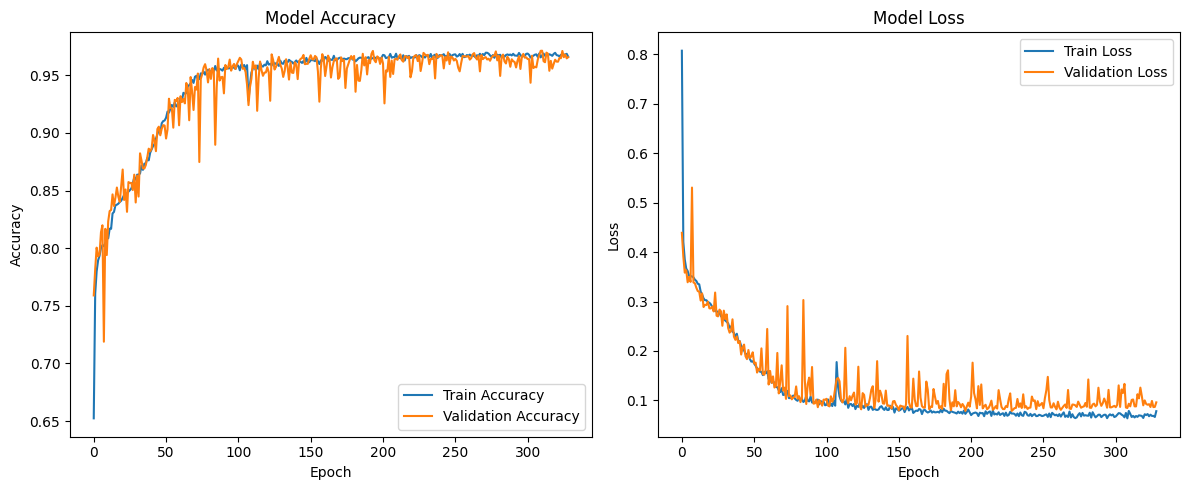

In [128]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# --- Plotting Metrics ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [129]:
from sklearn.metrics import f1_score

# load the best model
from tensorflow.keras.models import load_model

dnn_model = load_model("dnp3_best_model.h5")

# Predict class probabilities for the test set
y_pred_prob = dnn_model.predict(X_test)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate macro-averaged F1 score for multi-class classification
f1 = f1_score(y_true, y_pred, average="macro")
acc = accuracy_score(y_true, y_pred)
print(f"F1 Score (macro): {f1:.4f}, Accuracy: {acc:.4f}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1 Score (macro): 0.9285, Accuracy: 0.9695


#### Torch 

In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np


class CustomDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        labels_key: str = "Label",
        split: str = "train",
        random_state: int = 42,
        max_data: int = -1,
        train_size: float = 0.75,
    ):
        self.train_size = train_size
        self.df = df
        class_names = df[labels_key].unique()
        class_names.sort()
        self.class_names = class_names
        self.class_encoder = {name: i for i, name in enumerate(class_names)}

        self.df = self.df.sample(
            frac=1.0, random_state=random_state, replace=False
        ).reset_index(drop=True)

        if max_data > 0:
            self.df = self.df.iloc[:max_data]

        self.labels = self.df[labels_key].values
        self.features = self.df.drop(columns=[labels_key]).values

        self.scaler = MinMaxScaler()
        self.features = self.scaler.fit_transform(self.features)

        self.split = split
        self.random_state = random_state
        self._split_data()
        self._one_hot_encode_labels()

    def _split_data(self):
        if self.split == "train":
            self.features = self.features[: int(len(self.features) * self.train_size)]
            self.labels = self.labels[: int(len(self.labels) * self.train_size)]
        else:
            self.features = self.features[int(len(self.features) * self.train_size) :]
            self.labels = self.labels[int(len(self.labels) * self.train_size) :]

    def _one_hot_encode_labels(self):
        labels = np.zeros((self.labels.shape[0], len(self.class_names)))
        for i, label in enumerate(self.labels):
            labels[i, self.class_encoder[label]] = 1
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if idx == len(self.labels) - 1:
            idxs = np.arange(len(self.labels))
            np.random.shuffle(idxs)
            self.features = self.features[idxs]
            self.labels = self.labels[idxs]

        return torch.from_numpy(self.features[idx]).to(torch.float32), torch.from_numpy(
            self.labels[idx]
        ).to(torch.float32)


df = combined_df.copy()
# df = oversample_class(df, "Label")
max_data = -1
train_dataset = CustomDataset(df, split="train", max_data=max_data)
test_dataset = CustomDataset(df, split="test", max_data=max_data)
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for features, labels in train_loader:
    print(f"Features: {features.shape}, Labels: {labels.shape}")
    break

Features: torch.Size([32, 95]), Labels: torch.Size([32, 9])


In [131]:
# --- Define the DNN model ---
class DNP3DNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DNP3DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, 90),
            nn.ReLU(),
            nn.Linear(90, output_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.net(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_data = -100
train_dataset = CustomDataset(df, split="train", max_data=max_data)
test_dataset = CustomDataset(df, split="test", max_data=max_data)
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_dim = train_dataset.features.shape[1]
output_dim = train_dataset.labels.shape[1]
model = DNP3DNN(input_dim, output_dim)
model.to(device)

# --- Training setup ---
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 1000
log_every = 1
# --- Training loop ---
train_losses = []
train_accs = []

test_losses = []
test_accs = []
max_acc = 0.0
max_epoch = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    acc = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)

        acc += (
            (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)).float().sum()
        )

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss = running_loss / len(train_loader.dataset)
    acc /= len(train_loader.dataset)
    train_losses.append(loss)
    train_accs.append(acc)

    # --- Evaluation ---
    model.eval()
    running_loss = 0.0
    acc = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            acc += (
                (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1))
                .float()
                .sum()
            )
    loss = running_loss / len(test_loader.dataset)
    acc /= len(test_loader.dataset)
    if acc > max_acc:
        max_acc = acc
        max_epoch = epoch
        torch.save(model.state_dict(), "dnp3_dnn_best_model.pth")
    test_losses.append(loss)
    test_accs.append(acc)
    if epoch % log_every == 0:
        logger.info(
            f"Epoch [{epoch}/{num_epochs}], "
            f"Train Loss: {loss:.4f}, Train Acc: {acc:.4f}, "
            f"Test Loss: {loss:.4f}, Test Acc: {acc:.4f}, "
            f"Max Acc: {max_acc:.4f} @ {max_epoch} epoch"
        )

2025-05-18 23:09:26.221 | INFO     | __main__:<module>:106 - Epoch [0/1000], Train Loss: 0.0047, Train Acc: 0.6301, Test Loss: 0.0047, Test Acc: 0.6301, Max Acc: 0.6301 @ 0 epoch
2025-05-18 23:09:31.957 | INFO     | __main__:<module>:106 - Epoch [1/1000], Train Loss: 0.0044, Train Acc: 0.5883, Test Loss: 0.0044, Test Acc: 0.5883, Max Acc: 0.6301 @ 0 epoch
2025-05-18 23:09:37.699 | INFO     | __main__:<module>:106 - Epoch [2/1000], Train Loss: 0.0043, Train Acc: 0.6118, Test Loss: 0.0043, Test Acc: 0.6118, Max Acc: 0.6301 @ 0 epoch
2025-05-18 23:09:43.378 | INFO     | __main__:<module>:106 - Epoch [3/1000], Train Loss: 0.0041, Train Acc: 0.6734, Test Loss: 0.0041, Test Acc: 0.6734, Max Acc: 0.6734 @ 3 epoch
2025-05-18 23:09:48.823 | INFO     | __main__:<module>:106 - Epoch [4/1000], Train Loss: 0.0039, Train Acc: 0.6821, Test Loss: 0.0039, Test Acc: 0.6821, Max Acc: 0.6821 @ 4 epoch
2025-05-18 23:09:54.290 | INFO     | __main__:<module>:106 - Epoch [5/1000], Train Loss: 0.0037, Train Ac

In [141]:
# F1 score
from sklearn.metrics import f1_score

best_model = DNP3DNN(input_dim, output_dim)
best_model.load_state_dict(torch.load("dnp3_dnn_best_model.pth", map_location=device))

f1 = 0.0
acc = 0.0
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = best_model.to(device)(features)
        acc += (
            (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)).float().sum()
        )

        y_true.extend(torch.argmax(labels, dim=1).cpu().numpy().tolist())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy().tolist())

    acc /= len(test_loader.dataset)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    print("F1 Score (macro):", f1_macro)
    print("F1 Score (weighted):", f1_weighted)
    logger.info(f"Test Accuracy: {acc:.4f}")

2025-05-19 08:11:36.547 | INFO     | __main__:<module>:29 - Test Accuracy: 0.9602


F1 Score (macro): 0.9128811147313686
F1 Score (weighted): 0.9602131655810506


F1 Score (macro): 0.912880719107735
F1 Score (weighted): 0.9602131603368186
